<a href="https://colab.research.google.com/github/Bahrombekk/pytorch/blob/main/Data_IMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn.functional as F
import glob

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# from torchinfo import summary
from torchsummary import summary
import pathlib
from PIL import Image
from torchvision.transforms import transforms
from torch.optim import Adam

import torchvision.transforms as T

In [63]:
!pip install torchinfo

#MNIST_PNG(LeNet)

In [64]:
!wget https://github.com/JavohirJalilov/Datasets/raw/main/Classification/mnist_png.tar.gz

--2023-07-07 13:53:42--  https://github.com/JavohirJalilov/Datasets/raw/main/Classification/mnist_png.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JavohirJalilov/Datasets/main/Classification/mnist_png.tar.gz [following]
--2023-07-07 13:53:43--  https://raw.githubusercontent.com/JavohirJalilov/Datasets/main/Classification/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz’

mnist_png.tar.gz    100%[===================>]  14.96M  --.-KB/s    in 0.1s    

2023-07-07 13:53:43 (134 MB/s) - ‘mnist_png.tar.gz

tar"!tar -xzf /content/mnist_png.tar.gz" kodi "/content" katalogida joylashgan "mnist_png.tar.gz" faylining mazmunini chiqarish uchun Linux buyrug'idan foydalanadi . Bayroqlar -xzffaylni chiqarish va gzip siqishini boshqarish uchun ishlatiladi.

Qidiruv natijalariga asoslanib, ushbu buyruq odatda MNIST ma'lumotlar to'plami bo'yicha treningni o'z ichiga olgan mashinani o'rganish loyihalarida qo'llaniladi, bu tasvirni aniqlash vazifalari uchun ishlatiladigan qo'lda yozilgan raqamlar ma'lumotlar to'plamidir. Ma'lumotlar to'plami odatda "mnist_png.tar.gz" kabi siqilgan arxiv fayli shaklida taqdim etiladi.

Umuman olganda, "!tar -xzf /content/mnist_png.tar.gz" buyrug'i Linux operatsion tizimida siqilgan arxiv fayli tarkibini osongina chiqarib olish usulidir.

In [65]:
!tar -xzf /content/mnist_png.tar.gz

"Device = 'cuda' if torch.cuda.is_available() aks holda 'cpu'" kod qismi "cuda" qatorini "device" o'zgaruvchisiga tayinlaydi, agar torch.cuda.is_available() funksiyasi True qiymatini qaytarsa, bu a ekanligini ko'rsatadi CUDA yoqilgan GPU foydalanish uchun mavjud. Aks holda, "cpu" qatori "qurilma" o'zgaruvchisiga tayinlanadi, bu esa CPU o'rniga hisoblash uchun ishlatilishi kerakligini ko'rsatadi.

Ushbu kod odatda tezroq o'qitish vaqtlari uchun GPUda ishlashi mumkin bo'lgan chuqur o'rganish dasturlarida qo'llaniladi. Qurilmani tayinlashdan oldin GPU mavjudligini tekshirish orqali kod uning GPU yoqilgan va faqat protsessorli mashinalarda muvaffaqiyatli ishlashini ta'minlaydi.

Umuman olganda, ushbu kod mavjudligiga qarab PyTorch-da GPU va CPU resurslaridan foydalanish o'rtasida almashishning oqlangan usulini taqdim etadi.

In [66]:
device='cuda' if  torch.cuda.is_available() else 'cpu'
device

'cuda'

In [67]:
class MNISTDataset(Dataset):

    def __init__(self, path, transform = None):
        # int for cross entryp loss
        self.path_list = list(path.glob('*/*.png'))
        self.transform = transform

    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]

        if transform != None:
            img = transform(img)

        return img, int(label)

    def __len__(self):
        return len(self.path_list)

In [68]:
train_path=pathlib.Path("/content/mnist_png/training")
test_path=pathlib.Path("/content/mnist_png/testing")

"Transform=T.Compose([ T.Resize(size=32), T.ToTensor() ])" kodi PyTorch ma'lumotlar to'plami joylashgan Python mashina o'rganish ilovalarida tasvir ma'lumotlariga qo'llanilishi uchun ikkita operatsiyadan iborat transformatsiya quvurini yaratadi. ishlatilgan. Ushbu konfiguratsiya odatda chuqur o'rganish modellarini o'rgatish uchun tasvir ma'lumotlar to'plamini tayyorlash uchun ishlatiladi.

T.Compose klassi bir nechta transformatsiyalarni bitta quvur liniyasiga birlashtirish uchun ishlatiladi. Bunday holda, quvur liniyasi ikkita transformatsiyadan iborat:

T.Resize(size=32): Bu oʻzgartirish kiritilgan tasvir maʼlumotlarini oʻlchamlari (32 x 32) boʻlgan kvadrat shaklga ega boʻlish uchun oʻzgartiradi. O'lchamini o'zgartirish - bu ko'plab chuqur o'rganish modellari tomonidan talab qilinadigan barcha tasvirlarni bir xil o'lchamda qilish uchun kompyuter ko'rish ilovalarida keng tarqalgan operatsiya.
T.ToTensor(): Ushbu o'zgartirish kiritilgan tasvir ma'lumotlarini NumPy massividan PyTorch tensoriga aylantiradi. Bu juda muhim, chunki PyTorch kabi chuqur o'rganish ramkalari kirishlar tenzor formatida bo'lishini talab qiladi.
Umuman olganda, transform=T.Compose([ T.Resize(size=32), T.ToTensor() ]) kod parchasi mashinada foydalanish uchun tasvir maʼlumotlarini oʻlchamini oʻzgartiruvchi va tenzor formatiga oʻzgartiruvchi transformatsion quvur liniyasini yaratish uchun ishlatiladi. PyTorch ma'lumotlar to'plamini o'z ichiga olgan o'rganish ilovalari.

In [69]:
transform=T.Compose([
    T.Resize(size=32),
    T.ToTensor()
])

In [70]:
train_dataset=MNISTDataset(train_path,transform)
test_dataset=MNISTDataset(test_path,transform)

datani bachlarga bo'lib trenga beradi

In [71]:
train_data = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [72]:
img, label = next(iter(test_dataset))

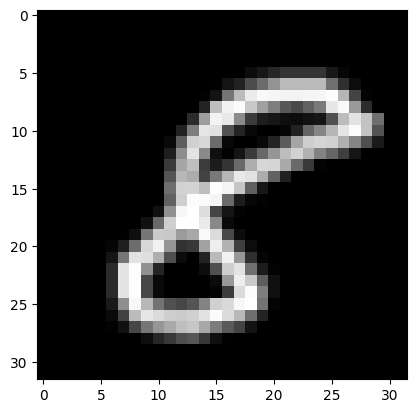

In [73]:
plt.imshow(img[0],cmap='gray')

Madel arxitektura
lenet-5.svg

nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=0)

in_channels: kirish kanallari soni. Bunday holda, kirish bitta kanalli tasvirlardan iborat bo'ladi, masalan, kulrang rangdagi tasvirlar.

out_channels: kirishga qo'llamoqchi bo'lgan filtrlar soniga mos keladigan chiqish kanallari soni. Bunday holda, chiqish 6 ta kanalga ega bo'lishi kerak.

kernel_size: konvolyutsion yadroning o'lchami, ya'ni kirish ustiga siljiydigan oyna. Bunday holda, yadro 5x5 (ya'ni, kengligi 5 piksel va balandligi 5 piksel).

stride: har bir konvolyutsiyadan keyin oyna qancha harakatlanishini aniqlaydigan konvolyutsion yadroning qadami. Bunday holda, qadam 1 ga o'rnatiladi, ya'ni yadro bir vaqtning o'zida bir piksel harakat qiladi.

padding: kiritish uchun qo'llaniladigan to'ldirish miqdori. Konvolyutsion qatlamning chiqishi kirish bilan bir xil o'lchamlarga ega bo'lishini ta'minlash uchun to'ldirish qo'llaniladi. Bunday holda, to'ldirish 0 ga o'rnatiladi, ya'ni kiritishga hech qanday to'ldirish qo'shilmaydi.


nn.AvgPool2d - bu rasimni 2d ko'rinishga o'tkazib beradi

nn.Tanh() - bu PyTorch faollashtirish funksiyasi bo'lib, u kirish tenzor elementi bo'yicha giperbolik tangens funksiyasini qo'llaydi. U neyron tarmoqlarda faollashtirish funktsiyasi sifatida keng qo'llaniladi, chunki u farqlanishi mumkin va tarmoqqa chiziqli bo'lmaganlikni kiritishi mumkin, bu esa kirish va chiqishlar o'rtasidagi murakkabroq xaritalarni o'rganish imkonini beradi.

PyTorch da nn.Tanh() mustaqil funksiya sifatida yoki kattaroq neyron tarmoq arxitekturasining bir qismi sifatida ishlatilishi mumkin. Neyron tarmoqda nn.Tanh() dan foydalanish uchun uni nn.Sequential() konteyneri yordamida qatlam sifatida qo'shish mumkin.

nn.Tanh() ning chiqishi (-1, 1) oralig'ida bo'ladi, ya'ni kuchli salbiy kirishlar salbiy natijalarga va kuchli ijobiy kirishlar ijobiy natijalarga moslashtiriladi. Faqat nolga yaqin kirishlar nolga yaqin chiqishlar bilan taqqoslanadi, bu esa yo'qolib borayotgan gradient muammosini hal qilishga yordam beradi.

nn.Linear() - PyTorch funktsiyasi nn.Linear() kirish tensoriga chiziqli transformatsiyani qo'llaydi. Xususan, u oʻrganish mumkin boʻlgan ogʻirlik matritsasi bilan kiritilgan maʼlumotlarni matritsali koʻpaytirishni amalga oshiradi va oʻrganish mumkin boʻlgan tarafkashlik atamasini qoʻshadi. Chiqish tensori kirish tenzori bilan bir xil shaklga ega, konstruktorda ko'rsatilgan chiqish xususiyatlarining soniga teng bo'lgan oxirgi o'lchov bundan mustasno.

nn.Linear() sinfining konstruktori ikkita argumentni oladi:

in_features: har bir kirish namunasining o'lchami
out_features: har bir chiqish namunasi hajmi
Masalan, nn.Linear(784, 256)784 ta kirish xususiyati va 256 ta chiqish xususiyatiga ega chiziqli qatlam hosil qiladi.

nn.Linear() funksiyasi odatda neyron tarmoq arxitekturasining bir qismi sifatida boshqa qatlamlar va faollashtirish funksiyalari bilan birga ishlatiladi. U tasniflash yoki regressiya kabi vazifalar uchun ishlatilishi mumkin, bunda kirish xususiyatlari chiziqli transformatsiyadan so'ng chiziqli bo'lmagan faollashtirish funktsiyalari orqali pastki o'lchamli bo'shliqqa aylanadi.

nn.Linear() qatlamining og'irliklari va noaniqliklari tasodifiy ishga tushirish yoki oldindan o'rgatilgan og'irliklar kabi turli usullar yordamida ishga tushirilishi mumkin. Trening davomida og'irliklar va noaniqliklar stoxastik gradient descent (SGD) yoki Adam kabi optimallashtirish algoritmi yordamida yangilanadi.

In [74]:
class LeNet(nn.Module):
  def __init__(self):
      super(LeNet,self).__init__()
      #32x32x1
      self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=0)
      #28x28x6
      self.conv2=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0)
      #14x14x6
      self.conv3=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5,stride=1,padding=0)
      #10x10x16
      #AVG POLL 5x5x16
      self.linear1=nn.Linear(120,84)
      self.linear2=nn.Linear(84,10)
      self.tanh=nn.Tanh()
      self.avgpool=nn.AvgPool2d(kernel_size=2,stride=2)
  def forward(self,x):
      #32x32x1
      x=self.conv1(x)
      x=self.tanh(x)
      #28x28x6
      x=self.avgpool(x)
      #14x14x6
      x=self.conv2(x)
      #10x10x16
      x=self.tanh(x)
      x=self.avgpool(x)
      #5x5x16
      x=self.conv3(x)
      #1x1x120
      x=self.tanh(x)
      x=x.reshape(x.shape[0],-1)
      #120
      x=self.linear1(x)
      #84
      x=self.tanh(x)
      #84
      x=self.linear2(x)
      #10
      return x

In [75]:
model=LeNet()

nn.CrossEntropyLoss() ko'p sinfli tasniflash muammolari uchun ishlatiladigan PyTorch yo'qotish funktsiyasidir. Ushbu yo'qotish funktsiyasi log softmax funktsiyasini va salbiy log ehtimollik yo'qolishini bitta funktsiyaga birlashtiradi. nn.CrossEntropyLoss() ga kirish normallashtirilmagan logitlar bo'lishi kerak va maqsad sinf indeksi tenzori bo'lishi kerak, bunda har bir element har bir misol uchun to'g'ri sinfni ifodalaydi.

nn.CrossEntropyLoss() funksiyasi neyron tarmoqning chiqishiga Softmax funksiyasini qo'llaydi va keyin bashorat qilingan sinf ehtimolliklari va haqiqiy sinf ehtimolliklari o'rtasidagi o'zaro entropiya yo'qotilishini hisoblab chiqadi. U odatda tasvirni tasniflash vazifalarida qo'llaniladi, bu erda maqsad tasvirni bir nechta sinflardan biriga to'g'ri tasniflashdir.

Funktsiya bir nechta ixtiyoriy argumentlarni oladi, jumladan, vazn, o'lcham_o'rtacha, ignore_index, kamaytirish va kamaytirish, ular yo'qotish funksiyasining harakatini sozlash uchun ishlatilishi mumkin.

nn.CrossEntropyLoss() odatda neyron tarmoqni o'rgatish uchun SGD yoki Adam kabi optimallashtiruvchi bilan birgalikda ishlatiladi. Trening davomida optimallashtiruvchi nn.CrossEntropyLoss() tomonidan yaratilgan yo'qotishlarni minimallashtirish uchun neyron tarmoqning og'irliklarini moslashtiradi.

PyTorch torch.optim.Adam deb nomlangan alohida sinfni taqdim etadi, bu stokastik gradient tushishi uchun Adam optimallashtirish algoritmini amalga oshirishdir.

Torch.optim.Adam klassi berilgan yo'qotish funksiyasini minimallashtirish uchun mashg'ulot vaqtida neyron tarmoqni optimallashtirish uchun ishlatiladi. Unda o'rganish tezligi, beta va epsilon kabi o'rnatilishi mumkin bo'lgan bir nechta giperparametrlar mavjud.

Torch.optim.Adam dan foydalanish uchun avvalo sinfning namunasini yaratishingiz va optimallashtiriladigan parametrlarni va giperparametrlarni argument sifatida topshirishingiz kerak. Keyin, har bir trening iteratsiyasi davomida, ushbu parametrlarga nisbatan yo'qotish funksiyasining gradienti asosida parametrlarni yangilash uchun optimallashtiruvchining step() usulini chaqirishingiz kerak.

In [76]:
learning_rate=0.001
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [77]:
num_epochs=10

Pythonda o'rnatilgan "enumerate()" funksiyasi takrorlanadigan ob'ektga hisoblagich qo'shish va tsikllar uchun ishlatilishi yoki kortejlar ro'yxatiga aylantirilishi mumkin bo'lgan sanab o'tilgan ob'ektni qaytarish uchun ishlatiladi.

Pythondan tashqarida, "sanoqlash" atamasi ro'yxat yoki ketma-ketlikdagi elementlarning sonini sanash yoki aniqlash ma'nosini bildiruvchi fe'l sifatida ham ishlatilishi mumkin.

Mulkni boshqarish dasturiy ta'minoti kontekstida "Enumerate" bu mulkni boshqarish uchun buxgalteriya hisobini boshqarish, aloqa, jalb qilish va hisobot berish vositalarini birlashtirgan dasturiy platformaning nomi.

Ba'zi kontekstlarda "sanoqlash" "element" yoki "ro'yxat" ning sinonimi sifatida ishlatiladi, bu har bir elementni ketma-ketlikda alohida-alohida oshirish tartibida belgilashni anglatadi.. Misol uchun, siz argumentdagi kamchiliklarni sanab o'tishingiz yoki jarayondagi bosqichlarni sanab o'tishingiz mumkin.

Tqdm - bu Python kutubxonasi bo'lib, u iteratorlar uchun progress barlarini taqdim etadi va tsikl yoki boshqa iteratsiya jarayonini kuzatish uchun ishlatilishi mumkin. “Tqdm” nomi “taqadum”ning qisqartmasi bo‘lib, arabcha “taraqqiyot” ma’nosini bildiradi. Bu uzoq muddatli hisoblash yoki katta hajmdagi ma'lumotlarni o'z ichiga olgan vazifaning borishini ko'rsatish uchun foydali bo'lishi mumkin.

Tqdm kutubxonasi juda ko'p qirrali bo'lib, uni bir necha usulda ishlatish mumkin. Tqdm dan foydalanishning eng keng tarqalgan usullaridan biri bu tsikl yoki generator kabi takrorlanuvchini "tqdm()" funksiyasi bilan o'rashdir. Shu tarzda foydalanilganda, tqdm avtomatik ravishda bajarilish foizini va operatsiya uchun qolgan taxminiy vaqtni ko'rsatadigan progress satrini ko'rsatadi.

Tqdm kutubxonasi yuqori darajadagi sozlash imkonini beradi va taraqqiyot satrining ko'rinishi va xatti-harakatlarini boshqarish uchun ishlatilishi mumkin bo'lgan ko'plab parametrlarni taqdim etadi. Masalan, siz progress satrining tavsifini belgilashingiz, kutilgan takrorlashlarning umumiy sonini belgilashingiz mumkin, va agar xohlasangiz, harakatlanish panelini butunlay o'chirib qo'ying.

Tqdm-ni pip yoki conda yordamida o'rnatish mumkin va paketni GitHub omboridan ham yuklab olish mumkin. Kutubxona MIT Open Source License ostida tarqatiladi va manba kodi GitHub da mavjud.

.argmax()turli xil Python kutubxonalarida, jumladan NumPy, PyTorch va pandalarda mavjud boʻlgan usul boʻlib, massivdagi yoki belgilangan oʻq boʻyicha tensordagi maksimal qiymat indekslarini qaytaradi..

NumPy ilovasi .argmax()massivning oʻqi yoki oʻqlari boʻyicha maksimal qiymatlar indekslarini qaytaradi.. Xuddi shunday, PyTorch-ning amalga oshirilishi .argmax()bir yoki bir nechta o'lchamlar bo'yicha tensorning maksimal qiymatlari indekslarini qaytaradi.. Boshqa tomondan, pandasning amalga oshirilishi .argmax()Seriyadagi maksimal qiymatning qator o'rnini qaytaradi.

Shuni ta'kidlash kerakki, .argmax()ba'zida GPU-da ishlamay qolishi mumkin, qidiruv natijalaridan birida tasvirlanganidek. Shuni ham ta'kidlash joizki, taqdim etilgan kodda uchraydigan xato DataFrame usuli NumPy massivini emas, balki bog'langan metod ob'ektini qaytarayotgani bilan bog'liq bo'lishi mumkin , shuning uchun undan to_numpy()foydalanishga urinayotganda AttributeError ..argmax()

Umuman olganda, .argmax()massiv yoki tensorda maksimal qiymat indeksini topish uchun ko'plab ma'lumotlarni tahlil qilish va mashinani o'rganish kontekstlarida foydali usul.

In [78]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}

    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # bashorat qilish modeli
            output = self.model(data)
            # yo'qotishni loss
            loss = self.criterion(output, label)

            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n

        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)

        return train_loss, train_accuracy

    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # bashorat qilish modeli
            output = self.model(data)
            # yo'qotishni loss
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()

            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)

        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n

        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)

        return val_loss, val_accuracy

    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [79]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [80]:
trainer.train()

100%|██████████| 157/157 [00:04<00:00, 33.20it/s]



Epoch[1/10] 	 train_loss: 0.27900, train_acc: 0.92 	 val_loss: 0.10416 	 val_acc: 0.97


100%|██████████| 157/157 [00:04<00:00, 33.82it/s]



Epoch[2/10] 	 train_loss: 0.08744, train_acc: 0.97 	 val_loss: 0.06569 	 val_acc: 0.98


100%|██████████| 157/157 [00:04<00:00, 34.15it/s]



Epoch[3/10] 	 train_loss: 0.05978, train_acc: 0.98 	 val_loss: 0.07003 	 val_acc: 0.98


100%|██████████| 157/157 [00:05<00:00, 31.13it/s]



Epoch[4/10] 	 train_loss: 0.04688, train_acc: 0.99 	 val_loss: 0.04302 	 val_acc: 0.99


100%|██████████| 157/157 [00:05<00:00, 29.12it/s]



Epoch[5/10] 	 train_loss: 0.03736, train_acc: 0.99 	 val_loss: 0.04465 	 val_acc: 0.99


100%|██████████| 157/157 [00:05<00:00, 31.01it/s]



Epoch[6/10] 	 train_loss: 0.02978, train_acc: 0.99 	 val_loss: 0.05376 	 val_acc: 0.98


100%|██████████| 157/157 [00:04<00:00, 34.67it/s]



Epoch[7/10] 	 train_loss: 0.02636, train_acc: 0.99 	 val_loss: 0.04330 	 val_acc: 0.99


100%|██████████| 157/157 [00:04<00:00, 34.06it/s]



Epoch[8/10] 	 train_loss: 0.02118, train_acc: 0.99 	 val_loss: 0.03897 	 val_acc: 0.99


100%|██████████| 157/157 [00:04<00:00, 34.39it/s]



Epoch[9/10] 	 train_loss: 0.01928, train_acc: 0.99 	 val_loss: 0.04487 	 val_acc: 0.99


100%|██████████| 157/157 [00:04<00:00, 32.83it/s]


Epoch[10/10] 	 train_loss: 0.01543, train_acc: 1.00 	 val_loss: 0.04132 	 val_acc: 0.99


PyTorch-da "next(iter(test_loader))" ga qo'ng'iroq qilish "test_loader" DataLoader obyektidan keyingi ma'lumotlar va teglar to'plamini qaytaradi. Bu PyTorch-dagi DataLoaders-dan foydalanib, ma'lumotlar to'plamini to'plamlarda takrorlashning keng tarqalgan usuli.

Xuddi shunday, TensorFlow'da "keyingi (iter (test_data))" chaqiruvi "test_data" ma'lumotlar to'plami ob'ektidagi ma'lumotlar va teglarning keyingi partiyasini qaytaradi. Bu, shuningdek, TensorFlow-dagi ma'lumotlar to'plamidan foydalangan holda ma'lumotlar to'plamini to'plamlarda takrorlashning keng tarqalgan usuli.

Umuman olganda, "next(iter())" chaqiruvi ma'lumotlar to'plami yoki DataLoader ob'ekti orqali to'plamlarda iteratsiya qilishning keng tarqalgan namunasidir va undan PyTorch va TensorFlow-da ham foydalanish mumkin.

PyTorch yoki TensorFlow kabi mashinani o'rganish tizimi kontekstida tensorda ".detach().cpu()" ni chaqirish uni NumPy massiviga aylantirishning keng tarqalgan usuli hisoblanadi, shu bilan birga uning hisoblash grafikidan va CPU xotirasida saqlanadi.

Detach() usuli tensorni hisoblash grafigidan olib tashlash uchun ishlatiladi, ya'ni tensor endi modelni o'rgatish uchun orqaga tarqalish operatsiyalari uchun ishlatilmaydi. detach() dan so'ng cpu() ga qo'ng'iroq qilish, tensor dastlab GPUda bo'lgan taqdirda, GPU xotirasidan farqli o'laroq, protsessor xotirasida saqlanishini ta'minlaydi. Bu ko'pincha NumPy-dan foydalanganda kerak bo'ladi, chunki u GPU operatsiyalarini qo'llab-quvvatlamaydi.

Xulosa qilib aytganda, “pred.detach().cpu()” chaqirilishi tensorni NumPy massiviga aylantirish va uni hisoblash grafikidan ajratib, protsessor xotirasiga o‘tkazish usulidir. Bu PyTorch yoki TensorFlowni o'z ichiga olgan mashinani o'rganish dasturlarida keng tarqalgan operatsiya.

"From sklearn.metrics import confusion_matrix" import bayonoti tasniflash modelining ishlashini baholashni o'z ichiga olgan Python mashina o'rganish ilovalarida qo'llaniladi. Scikit-learn metrikalari moduli tomonidan taqdim etilgan confusion_matrix() funksiyasi tasniflash modelining bashoratli ishlashini baholash uchun ishlatiladigan jadval bo'lgan chalkashlik matritsasini hisoblaydi va qaytaradi.

Funktsiya kirish sifatida ikkita massivni oladi: y_true, unda haqiqiy teglar va y_pred, bashorat qilingan teglar mavjud. Keyin chalkashlik matritsasini qaytaradi, bu shaklning 2D massivi (n_classes, n_classes), bu erda n_classes y_true va y_pred-dagi noyob teglar sonidir.

Matritsadagi har bir c_ij elementi i sinfiga tegishli, lekin model bo'yicha j sinf sifatida tasniflangan kuzatuvlar sonini ifodalaydi. c_ii diagonal elementlari haqiqiy musbat (TP) sonini, diagonaldan tashqari elementlar esa noto'g'ri musbat (FP), noto'g'ri salbiy (FN) va haqiqiy salbiy (TN) ni ifodalaydi.

Umuman olganda, confusion_matrix() funktsiyasi tasniflash modellarining ishlashini baholash uchun foydali vosita bo'lib, u aniqlik, eslab qolish, F1 ball va aniqlik kabi boshqa baholash ko'rsatkichlari bilan birgalikda ishlatilishi mumkin.

tensor([9, 0, 5, 9, 0, 0, 2, 4, 2, 5, 5, 5, 2, 4, 6, 5, 3, 7, 1, 0, 5, 9, 4, 9,
        4, 7, 1, 9, 2, 8, 2, 6, 7, 7, 8, 0, 8, 9, 6, 2, 9, 5, 7, 7, 3, 6, 9, 6,
        2, 9, 1, 3, 8, 4, 0, 1, 6, 7, 2, 4, 8, 0, 6, 9])
[[ 7  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0]
 [ 1  0  7  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  1  0]
 [ 0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


<Axes: >

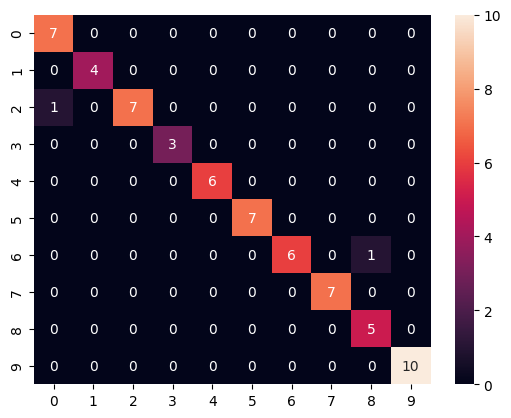

In [81]:
test_img,test_label=next(iter(test_data))
pred=model(test_img.to(device))
pred=pred.argmax(axis=1)
pred = pred.detach().cpu()
from sklearn.metrics import confusion_matrix
print( test_label)
cm=confusion_matrix(test_label,pred)
print(cm)
import seaborn as sns
sns.heatmap(cm,annot=True)

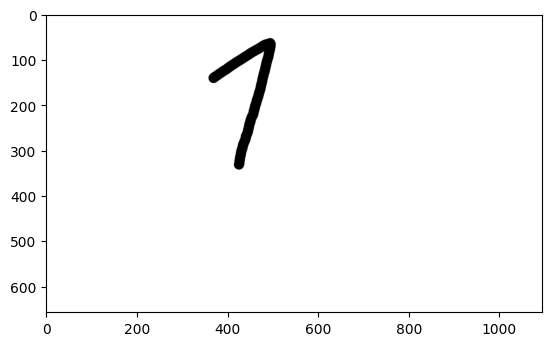

In [93]:

img="/content/1.png"
img=Image.open(img)
plt.imshow(img)
plt.show()


In [94]:
img_path = "/content/1.png"
img = Image.open(img_path)
transform = T.Compose([
        T.Resize(size=32),
        T.ToTensor()
    ])
img = transform(img)
img = img.unsqueeze(0)
model.eval()
with torch.no_grad():
    logits = model(img)
    predictions = np.argmax(torch.sigmoid(logits).detach().cpu().numpy(), axis=1)
print("Predicted label for the given image is: ", predictions)

RuntimeError: ignored

#Cat_and_Dog

In [95]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-07-07 14:47:59--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  97.4MB/s    in 0.7s    

2023-07-07 14:48:00 (97.4 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



cats_and_dogs_filtered.zipBerilgan kod nomli siqilgan faylni ochish va uning mazmunini nomli yangi katalogda saqlash buyrug'i kabi ko'rinadi data. Bayroq -dajratilgan fayllar uchun mo'ljallangan katalogni ko'rsatish uchun ishlatiladi.

Shuni yodda tutingki, bu kod to'g'ridan-to'g'ri Python skriptida emas, balki qobiq muhitida (masalan, Bash yoki Zsh) ishga tushirilgan. Buyruqning boshidagi belgi !notebook muhitidan qobiq buyruqlarini bajarish uchun Jupyter Notebook yoki Google Colab-ga xos sintaksisdir.

Agar siz ushbu kod bilan xatoga yo'l qo'ysangiz, aniqroq yo'l-yo'riq ko'rsatishim uchun xato xabarida nima deyilganini menga xabar bering.

In [ ]:
!unzip -d data cats_and_dogs_filtered.zip

In [97]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [98]:
transform = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])

In [99]:
class CATinDOGtaset(Dataset):

    def __init__(self, path, transform = None):
        # int for cross entryp loss
        self.path_list = list(path.glob('*/*.jpg'))
        self.transform = transform

    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]
        label = 0 if 'cat' in label else 1
        if transform != None:
            img = transform(img)

        return img, int(label)

    def __len__(self):
        return len(self.path_list)

In [100]:
train_path = pathlib.Path('/content/data/cats_and_dogs_filtered/train')
test_path = pathlib.Path('/content/data/cats_and_dogs_filtered/validation')

In [101]:
train_dataset = CATinDOGtaset(train_path, transform)
test_dataset = CATinDOGtaset(test_path, transform)

In [102]:
path_list = list(train_path.glob('*/*.jpg'))
path_test=list(test_path.glob('*/*.jpg'))

In [103]:
train_data = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=256, shuffle=True)

MODEL

In [104]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)

        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)

        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)

        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)

        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)

        output=self.fc(output)

        return output


In [105]:
model=ConvNet()

In [106]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [107]:
num_epochs = 5

In [108]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}

    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)

            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n

        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)

        return train_loss, train_accuracy

    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()

            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)

        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n

        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)

        return val_loss, val_accuracy

    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [109]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [110]:
trainer.train()

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]



Epoch[1/5] 	 train_loss: 15.55370, train_acc: 0.53 	 val_loss: 5.91936 	 val_acc: 0.55


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]



Epoch[2/5] 	 train_loss: 5.71770, train_acc: 0.58 	 val_loss: 2.39859 	 val_acc: 0.64


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]



Epoch[3/5] 	 train_loss: 3.51405, train_acc: 0.63 	 val_loss: 3.35376 	 val_acc: 0.62


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]



Epoch[4/5] 	 train_loss: 1.89298, train_acc: 0.71 	 val_loss: 1.94547 	 val_acc: 0.66


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch[5/5] 	 train_loss: 0.81703, train_acc: 0.79 	 val_loss: 1.94258 	 val_acc: 0.61


tensor([1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1])
[[ 42  73]
 [ 28 113]]


<Axes: >

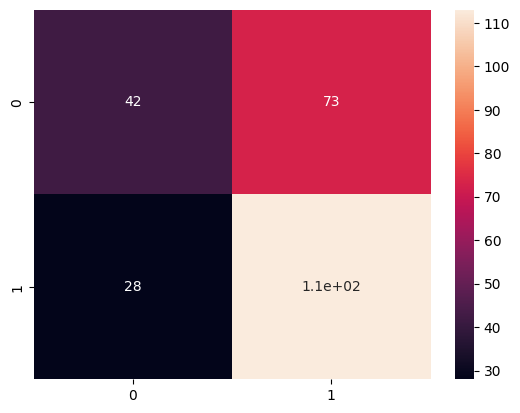

In [111]:
test_img,test_label=next(iter(test_data))
pred=model(test_img.to(device))
pred=pred.argmax(axis=1)
pred = pred.detach().cpu()
from sklearn.metrics import confusion_matrix
print( test_label)
cm=confusion_matrix(test_label,pred)
print(cm)
import seaborn as sns
sns.heatmap(cm,annot=True)

#CIFAR-10

In [112]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2023-07-07 14:53:00--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  52.0MB/s    in 3.1s    

2023-07-07 14:53:05 (52.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [113]:
!tar -xzf /content/cifar-10-python.tar.gz